## Link prediction using the discrete embeddings

In [2]:
import os
import numpy as np
import pandas as pd
import json
from sklearn import svm, datasets
import matplotlib.pyplot as plt
import random
import copy
from collections import Counter
import lightgbm as lgb
from sklearn import svm
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import accuracy_score as acc
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import roc_curve, auc, f1_score
from scipy import interp
import gc

In [7]:
graphnames = ['Cora', 'Citeseer', 'Pubmed', 'HomoSapiens', 'Wikipedia', 'BlogCatalog']
graphname = graphnames[0]
emb_size = 50
hop = 2
data_dir = os.path.expanduser("../Graphs/"+graphname)

In [8]:
rwalk_path = data_dir + "/vectors/vectors_rwalk_reduced_" + str(emb_size) + "_hop_" + str(hop) + ".json"
with open(rwalk_path, "r") as read_file:
    rwalk_vectors = json.load(read_file)

In [9]:
ns_path = data_dir + "/vectors/vectors_nodesketch_reduced_" + str(emb_size) + "_hop_" + str(hop) + ".json"
with open(ns_path, "r") as read_file:
    ns_vectors = json.load(read_file)

In [10]:
minwise_path = data_dir + "/vectors/vectors_minwise_reduced_" + str(emb_size) + "_hop_" + str(hop) + ".json"
with open(minwise_path, "r") as read_file:
    minwise_vectors = json.load(read_file)

In [11]:
l1_path = data_dir + "/vectors/vectors_l1_reduced_" + str(emb_size) + "_hop_" + str(hop) + ".json"
with open(l1_path, "r") as read_file:
    l1_vectors = json.load(read_file)

In [12]:
l2_path = data_dir + "/vectors/vectors_l2_reduced_" + str(emb_size) + "_hop_" + str(hop) + ".json"
with open(l2_path, "r") as read_file:
    l2_vectors = json.load(read_file)

In [13]:
# convert all per-node samples to vectors with categorical features 
def vectors_to_df(path_edges, vectors, x, emb_size=emb_size):
    edges_path = data_dir + path_edges 
    key = list(vectors.keys())[0]
    features = []
    labels = []
    nodes = set()
    edgeset = set()
    print('emb size', emb_size)
    with open(edges_path, 'r') as f:
        for nr, edge in enumerate(f):
            if nr % 10000 == 0:
                print(nr)
            vector_edge = {}
            edge_split = edge.split(':')
            u = edge_split[0].strip()
            v = edge_split[1].strip()
            nodes.add(u)
            nodes.add(v)
            if u not in vectors or v not in vectors:
                continue
            if len(vectors[u]) < emb_size or len(vectors[v]) < emb_size:
                continue
            edgeset.add((u,v))
            for i in range(emb_size): 
                u_i = vectors[u][i] 
                vector_edge['f' + str(2*i)] = str(u_i[x])
                v_i = vectors[v][i]
                vector_edge['f' + str(2*i+1)] = str(v_i[x])
                # vector_edge['f' + str(i)] = int(u_i[x]==v_i[x])
            features.append(vector_edge)
            labels.append(1)
    nr_pos = len(labels)
    print('Number of positive examples', nr_pos)
    nodeslist = list(nodes)
    for l in range(4*nr):
        u = nodeslist[random.randint(0, len(nodeslist)-1)]
        v = nodeslist[random.randint(0, len(nodeslist)-1)]
        if (u, v) not in edgeset and (v, u) not in edgeset:
            if u not in vectors or v not in vectors:
                continue
            if len(vectors[u]) < emb_size or len(vectors[v]) < emb_size:
                continue
            vector_edge = {}
            for i in range(emb_size): 
                u_i = vectors[u][i]
                vector_edge['f' + str(2*i)] = str(u_i[x])
                v_i = vectors[v][i]
                vector_edge['f' + str(2*i+1)] = str(v_i[x])
                #vector_edge['f' + str(i)] = int(u_i[x]==v_i[x])
            features.append(vector_edge)
            labels.append(0)
    print('Number of negative examples', len(labels)-nr_pos)        
    return pd.DataFrame(features), labels

In [15]:
minwise_vectors['35']

[['227178', 'label=Genetic_Algorithms', 'w-1304'],
 ['1071981', 'label=Reinforcement_Learning', 'w-111'],
 ['1104647', 'label=Genetic_Algorithms', 'w-80'],
 ['103482', 'label=Neural_Networks', 'w-225'],
 ['1105221', 'label=Genetic_Algorithms', 'w-1176'],
 ['503893', 'label=Genetic_Algorithms', 'w-455'],
 ['1103960', 'label=Genetic_Algorithms', 'w-931'],
 ['231249', 'label=Genetic_Algorithms', 'w-158'],
 ['141324', 'label=Genetic_Algorithms', 'w-528'],
 ['647447', 'label=Genetic_Algorithms', 'w-1297'],
 ['1128201', 'label=Genetic_Algorithms', 'w-582'],
 ['1109199', 'label=Genetic_Algorithms', 'w-25'],
 ['1152896', 'label=Case_Based', 'w-992'],
 ['1128227', 'label=Genetic_Algorithms', 'w-918'],
 ['124952', 'label=Probabilistic_Methods', 'w-1083'],
 ['1113551', 'label=Case_Based', 'w-758'],
 ['1103985', 'label=Genetic_Algorithms', 'w-1352'],
 ['1112911', 'label=Genetic_Algorithms', 'w-1292'],
 ['594387', 'label=Genetic_Algorithms', 'w-361'],
 ['1119505', 'label=Genetic_Algorithms', 'w-134

In [16]:
ns_vectors['35']

[['39474', 'label=Genetic_Algorithms', 'w-1090'],
 ['44368', 'label=Genetic_Algorithms', 'w-61'],
 ['427606', 'label=Genetic_Algorithms', 'w-19'],
 ['82920', 'label=Genetic_Algorithms', 'w-1207'],
 ['1153577', 'label=Genetic_Algorithms', 'w-368'],
 ['1114331', 'label=Genetic_Algorithms', 'w-1073'],
 ['190697', 'label=Genetic_Algorithms', 'w-1149'],
 ['1152508', 'label=Genetic_Algorithms', 'w-937'],
 ['35', 'label=Genetic_Algorithms', 'w-1247'],
 ['35061', 'label=Genetic_Algorithms', 'w-393'],
 ['634975', 'label=Genetic_Algorithms', 'w-1072'],
 ['198443', 'label=Genetic_Algorithms', 'w-1177'],
 ['62718', 'label=Case_Based', 'w-1114'],
 ['634938', 'label=Genetic_Algorithms', 'w-734'],
 ['634975', 'label=Genetic_Algorithms', 'w-1170'],
 ['103482', 'label=Neural_Networks', 'w-230'],
 ['14062', 'label=Genetic_Algorithms', 'w-25'],
 ['16485', 'label=Neural_Networks', 'w-1318'],
 ['35', 'label=Genetic_Algorithms', 'w-1305'],
 ['594543', 'label=Genetic_Algorithms', 'w-532'],
 ['592986', 'label

In [17]:
x = 2 # indicates what features to use, simply other nodes ids, the node labels or the words describing the nodes

In [18]:
paths = ['graph_nodes.txt', 'labels.txt', 'words_indices.txt']
features_path = data_dir + "/data/" + paths[x] 
features = []
with open(features_path, "r") as features_file:
    for f in features_file:
        features.append(f.strip())

In [19]:
features[:5]

['w-615', 'w-121', 'w-508', 'w-246', 'w-1102']

In [20]:
X_rwalk, y_rwalk = vectors_to_df(path_edges="/data/graph_edges_reduced.txt", vectors=rwalk_vectors, x=x)

emb size 50
0
Number of positive examples 4222
Number of negative examples 16868


In [21]:
X_ns, y_ns = vectors_to_df(path_edges="/data/graph_edges_reduced.txt", vectors=ns_vectors, x=x)

emb size 50
0
Number of positive examples 4222
Number of negative examples 16869


In [22]:
X_ns.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99
0,w-1090,w-324,w-61,w-61,w-19,w-19,w-1207,w-97,w-368,w-368,...,w-1172,w-918,w-623,w-1177,w-495,w-495,w-1301,w-1301,w-385,w-385
1,w-1090,w-324,w-61,w-61,w-19,w-19,w-1207,w-1207,w-368,w-368,...,w-1172,w-918,w-623,w-1177,w-495,w-495,w-1301,w-1301,w-385,w-1174
2,w-1090,w-324,w-61,w-61,w-19,w-19,w-1207,w-1207,w-368,w-368,...,w-1172,w-808,w-623,w-1177,w-495,w-495,w-1301,w-1301,w-385,w-385
3,w-1090,w-324,w-61,w-61,w-19,w-19,w-1207,w-1207,w-368,w-368,...,w-1172,w-898,w-623,w-1177,w-495,w-495,w-1301,w-1301,w-385,w-385
4,w-1090,w-324,w-61,w-61,w-19,w-19,w-1207,w-1207,w-368,w-368,...,w-1172,w-898,w-623,w-1177,w-495,w-495,w-1301,w-1301,w-385,w-385


In [23]:
X_minwise, y_minwise = vectors_to_df(path_edges="/data/graph_edges_reduced.txt", vectors=minwise_vectors, x=x)

emb size 50
0
Number of positive examples 4222
Number of negative examples 16865


In [24]:
X_l1, y_l1 = vectors_to_df(path_edges="/data/graph_edges_reduced.txt", vectors=l1_vectors, x=x)

emb size 50
0
Number of positive examples 4222
Number of negative examples 16862


In [25]:
X_l2, y_l2 = vectors_to_df(path_edges="/data/graph_edges_reduced.txt", vectors=l2_vectors, x=x)

emb size 50
0
Number of positive examples 4222
Number of negative examples 16866


In [26]:
X_val_rwalk, y_val_rwalk = vectors_to_df(path_edges="/data/removed_edges.txt", vectors=rwalk_vectors, x=x)

emb size 50
0
Number of positive examples 1056
Number of negative examples 4216


In [27]:
# Just a test to see sample distribution
# for i in range(50):
#  print(len(set(X_rwalk["f"+str(i)])), len(set(X_ns["f"+str(i)])), len(set(X_minwise["f"+str(i)])), \
#        len(set(X_l1["f"+str(i)])), len(set(X_l2["f"+str(i)]))) 

In [28]:
X_val_ns, y_val_ns = vectors_to_df(path_edges="/data/removed_edges.txt", vectors=ns_vectors, x=x)

emb size 50
0
Number of positive examples 1056
Number of negative examples 4216


In [29]:
X_val_minwise, y_val_minwise = vectors_to_df(path_edges="/data/removed_edges.txt", vectors=minwise_vectors, x=x)

emb size 50
0
Number of positive examples 1056
Number of negative examples 4213


In [30]:
X_val_l1, y_val_l1 = vectors_to_df(path_edges="/data/removed_edges.txt", vectors=l1_vectors, x=x)

emb size 50
0
Number of positive examples 1056
Number of negative examples 4213


In [31]:
X_val_l2, y_val_l2 = vectors_to_df(path_edges="/data/removed_edges.txt", vectors=l2_vectors, x=x)

emb size 50
0
Number of positive examples 1056
Number of negative examples 4216


In [32]:
X_rwalk.shape, X_ns.shape, X_minwise.shape, X_l1.shape, X_l2.shape

((21090, 100), (21091, 100), (21087, 100), (21084, 100), (21088, 100))

In [33]:
X_val_rwalk.shape, X_val_ns.shape, X_val_minwise.shape, X_val_l1.shape, X_val_l2.shape

((5272, 100), (5272, 100), (5269, 100), (5269, 100), (5272, 100))

In [34]:
X_val_l1.head(3)

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99
0,w-1204,w-128,w-192,w-192,w-819,w-819,w-1409,w-1156,w-1131,w-1131,...,w-819,w-819,w-1215,w-1215,w-829,w-829,w-474,w-1207,w-1379,w-1379
1,w-92,w-4,w-25,w-225,w-187,w-187,w-979,w-551,w-1131,w-1131,...,w-1036,w-87,w-979,w-675,w-859,w-1005,w-474,w-1299,w-1379,w-225
2,w-52,w-52,w-1314,w-25,w-490,w-187,w-1159,w-1156,w-708,w-1330,...,w-819,w-87,w-1315,w-979,w-104,w-1331,w-1314,w-118,w-530,w-1174


In [35]:
X_l1.head(3)

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99
0,w-464,w-613,w-225,w-225,w-1151,w-1071,w-202,w-1395,w-17,w-17,...,w-819,w-819,w-495,w-979,w-580,w-378,w-1299,w-1299,w-1174,w-1379
1,w-464,w-92,w-225,w-225,w-1151,w-382,w-202,w-1395,w-17,w-17,...,w-819,w-819,w-495,w-979,w-580,w-1046,w-1299,w-1299,w-1174,w-1379
2,w-464,w-92,w-225,w-225,w-1151,w-490,w-202,w-1395,w-17,w-17,...,w-819,w-819,w-495,w-979,w-580,w-1046,w-1299,w-1299,w-1174,w-1379


In [36]:
def predict(model, X, label_encoder):
    X_local = copy.deepcopy(X)
    for c in X_local.columns: 
        X_c = [str(x) for x in X_local[c]]
        X_local.loc[:, c] = label_encoder.transform(X_c)
    return model.predict(X_local)    
    

In [37]:
def get_mean_acc(X_train, y_train, X_val, y_val, features, nr_iters, res_path):
    
    accs = []  
    f1s = []
    aucs = []
    label_encoder = LabelEncoder()
    label_encoder.fit(features)
    
    X_train = copy.deepcopy(X_train)
        #encoders = {}
    for c in X_train.columns: 
        X_train.loc[:, c] = label_encoder.transform([str(x) for x in X_train[c]])
            
    X_val = copy.deepcopy(X_val)
    for c in X_val.columns: 
        #label_encoder = encoders[c]
        X_val.loc[:, c] = label_encoder.transform([str(x) for x in X_val[c]])
    
    models = [] 
    for i in range(nr_iters):
        print('Iter', i)
        
        X_train_clf, X_test, y_train_clf, y_test =  train_test_split(X_train, y_train, train_size=0.5)
        clf =  tree.DecisionTreeClassifier() 
        clf.fit(X_train_clf, y_train_clf)
        models.append(clf)
        y_pred = clf.predict(X_val)
#         model = lgbm_clf(X_train_clf, y_train_clf, X_test, y_test, label_encoder)
#         y_pred = model.predict(X_val) #predict(model, X_val, label_encoder)
        accuracy = acc(y_val, y_pred)
        accs.append(accuracy)
        
        f1 = f1_score(y_val, y_pred)
        f1s.append(f1)
        
        fpr, tpr, thresholds = roc_curve(y_val, y_pred)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        print('AUC', roc_auc)
        print('F1', f1)
    print('Accuracy', np.mean(accs), np.std(accs))
    print('AUC', np.mean(aucs), np.std(aucs))
    print('F1', np.mean(f1s), np.std(f1s))
    
    
    with open(res_path + "_accuracy.txt", "w") as f:
        f.write(str(np.mean(accs)) + " " + str(np.std(accs)))
    with open(res_path + "_F1.txt", "w") as f:
        f.write(str(np.mean(f1s)) + " " + str(np.std(f1s)))
    with open(res_path + "_AUC.txt", "w") as f:
        f.write(str(np.mean(aucs)) + " " + str(np.std(aucs)))
        
    return models[0], label_encoder
        

    



In [39]:
nr_iters = 10

In [40]:
res_path = data_dir + "/results/rwalk_" + str(emb_size) + "_hop_" + str(hop) 
clf_rw, le = get_mean_acc(X_rwalk, y_rwalk, X_val_rwalk, y_val_rwalk, features, nr_iters, res_path)

Iter 0
AUC 0.5726075987579783
F1 0.322324966974901
Iter 1
AUC 0.5558038281294921
F1 0.2943840579710145
Iter 2
AUC 0.545721386061756
F1 0.2839774207555362
Iter 3
AUC 0.5621918305445345
F1 0.3057040998217469
Iter 4
AUC 0.5533115188890805
F1 0.2920946851272889
Iter 5
AUC 0.5675241504226325
F1 0.3129496402877698
Iter 6
AUC 0.5456108763153356
F1 0.28154050464807434
Iter 7
AUC 0.5535612888850555
F1 0.288878634056299
Iter 8
AUC 0.5648099232361566
F1 0.30662983425414364
Iter 9
AUC 0.562079523891668
F1 0.3040723981900452
Accuracy 0.7036229135053111 0.007977109391075658
AUC 0.5583221925133689 0.008569738875029867
F1 0.2992556242086819 0.012525277911944433


In [41]:
res_path = data_dir + "/results/nodesketch_" + str(emb_size) + "_hop_" + str(hop) 
get_mean_acc(X_ns, y_ns, X_val_ns, y_val_ns, features, nr_iters, res_path)

Iter 0
AUC 0.6306773259157036
F1 0.4097222222222223
Iter 1
AUC 0.6280538425047438
F1 0.40509915014164305
Iter 2
AUC 0.6266585446495314
F1 0.40303797468354424
Iter 3
AUC 0.627002652233914
F1 0.4035346097201768
Iter 4
AUC 0.6191825153815191
F1 0.3906931652932623
Iter 5
AUC 0.62581220171353
F1 0.40154440154440146
Iter 6
AUC 0.6245121398999482
F1 0.3994169096209913
Iter 7
AUC 0.6290115936403887
F1 0.40679611650485437
Iter 8
AUC 0.616342504743833
F1 0.38596491228070173
Iter 9
AUC 0.6252255117589557
F1 0.40058765915768857
Accuracy 0.7670144157814871 0.005076270877669271
AUC 0.6252478832442068 0.004165833391775751
F1 0.4006397121169486 0.006863031036881246


(DecisionTreeClassifier(), LabelEncoder())

In [42]:
res_path = data_dir + "/results/minwise_" + str(emb_size) + "_hop_" + str(hop) 
clf_l0, le_l0 = get_mean_acc(X_minwise, y_minwise, X_val_minwise, y_val_minwise, features, nr_iters, res_path)

Iter 0
AUC 0.6252818656539283
F1 0.40076335877862596
Iter 1
AUC 0.6223358750692302
F1 0.39587426326129665
Iter 2
AUC 0.6145190481841918
F1 0.3829160530191458
Iter 3
AUC 0.6244585212437693
F1 0.39942112879884223
Iter 4
AUC 0.6333434706068518
F1 0.41396025206010667
Iter 5
AUC 0.6261237538571089
F1 0.4021526418786692
Iter 6
AUC 0.6307411583194873
F1 0.4097560975609756
Iter 7
AUC 0.6377173332542131
F1 0.4208015267175573
Iter 8
AUC 0.6261163363399004
F1 0.4021215043394407
Iter 9
AUC 0.626356169396313
F1 0.4025218234723569
Accuracy 0.7662744353767319 0.00321663527361516
AUC 0.6266993531924994 0.005975748807270558
F1 0.40302886498870166 0.009779204250369057


In [43]:
res_path = data_dir + "/results/l1_" + str(emb_size) + "_hop_" + str(hop) 
clf_l1, le_l1 = get_mean_acc(X_l1, y_l1, X_val_l1, y_val_l1, features, nr_iters, res_path)

Iter 0
AUC 0.6101142792151278
F1 0.37670267731329266
Iter 1
AUC 0.615807223672759
F1 0.38549618320610685
Iter 2
AUC 0.6186555502808766
F1 0.38996138996139
Iter 3
AUC 0.6308499485718807
F1 0.40976543800861653
Iter 4
AUC 0.6107324056491811
F1 0.37648221343873517
Iter 5
AUC 0.6151149220666192
F1 0.38377843719090016
Iter 6
AUC 0.6211404185457711
F1 0.39404132628543964
Iter 7
AUC 0.5990127284595301
F1 0.3564653020469296
Iter 8
AUC 0.6158158774428357
F1 0.3852498786996603
Iter 9
AUC 0.6108275971200254
F1 0.3777148253068933
Accuracy 0.7579237046877967 0.005391654099588614
AUC 0.6148070951024607 0.007863405330281409
F1 0.38356576714579643 0.013075241926612366


In [44]:
res_path = data_dir + "/results/l2_" + str(emb_size) + "_hop_" + str(hop) 
clf_l2, le_l2 = get_mean_acc(X_l2, y_l2, X_val_l2, y_val_l2, features, nr_iters, res_path)

Iter 0
AUC 0.6102860315680524
F1 0.3770949720670391
Iter 1
AUC 0.6040094373526537
F1 0.36727103672710365
Iter 2
AUC 0.5950186159507791
F1 0.3520456707897241
Iter 3
AUC 0.6151448665976654
F1 0.38457921955806296
Iter 4
AUC 0.5896880929791272
F1 0.34375
Iter 5
AUC 0.6068566356161232
F1 0.37134778510838834
Iter 6
AUC 0.5923969294462653
F1 0.35004557885141296
Iter 7
AUC 0.604372412454718
F1 0.36717267552182165
Iter 8
AUC 0.6063813538611925
F1 0.3707179727827311
Iter 9
AUC 0.6044874144672532
F1 0.3676539727315468
Accuracy 0.7432473444613049 0.005892468313756914
AUC 0.602864179029383 0.007649549699743719
F1 0.36516788841378306 0.012092458254271882


# Interpretability

In [45]:
def decision_path(clf, label_encoder, X_test, y_test, sample_id):
    
    feature = clf.tree_.feature
    threshold = clf.tree_.threshold
    
    X_test = copy.deepcopy(X_test)
    for c in X_test.columns: 
        #label_encoder = encoders[c]
        X_test.loc[:, c] = label_encoder.transform([str(x) for x in X_test[c]])
    
    node_indicator = clf.decision_path(X_test)
    leaf_id = clf.apply(X_test)

    # obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
    node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                        node_indicator.indptr[sample_id + 1]]

    print('Rules used to predict sample {id} with class {cl}:\n'.format(id=sample_id, cl=y_test[sample_id]))
    for node_id in node_index:
        # continue to the next node if it is a leaf node
        if leaf_id[sample_id] == node_id:
            continue

        print(feature[node_id])    
        # check if value of the split feature for sample 0 is below threshold
        if (X_test.iloc[sample_id, feature[node_id]] <= threshold[node_id]):
            threshold_sign = "<="
        else:
            threshold_sign = ">"
        
        print("decision node {node} : (X_test[{sample}, {feature}] = {value}) "
              "{inequality} {threshold})".format(
                  node=node_id,
                  sample=sample_id,
                  feature=feature[node_id],
                  value=label_encoder.inverse_transform([X_test.iloc[sample_id, feature[node_id]]]),
                  inequality=threshold_sign,
                  threshold=threshold[node_id]))
    print("prediction", clf.predict(X_test.iloc[[sample_id]]))

In [46]:
# text_representation = tree.export_text(clf_rw)
# print(text_representation)

In [47]:
decision_path(clf_l1, le_l1, X_val_l1, y_val_l1, 100)

Rules used to predict sample 100 with class 1:

66
decision node 0 : (X_test[100, 66] = ['w-65']) > 297.5)
67
decision node 1396 : (X_test[100, 67] = ['w-65']) > 297.5)
16
decision node 1616 : (X_test[100, 16] = ['w-751']) > 1155.0)
17
decision node 2038 : (X_test[100, 17] = ['w-619']) <= 1144.5)
49
decision node 2039 : (X_test[100, 49] = ['w-820']) > 55.0)
34
decision node 2043 : (X_test[100, 34] = ['w-118']) <= 214.5)
97
decision node 2044 : (X_test[100, 97] = ['w-118']) <= 302.5)
prediction [1]


In [48]:
#decision_path(clf_l1, le_l1, X_val_l1, y_val_l1, 180)

In [49]:
# text_representation = tree.export_text(clf_l1)
# print(text_representation)

In [53]:
def get_distr(X, y, label, indices):
    
    for idx in indices:
        X_label = X.iloc[[i for i, y_i in enumerate(y) if y_i==label], :]
        # X_neg = X.iloc[[i for i, y_i in enumerate(y) if y_i==0], :]
        print(X_label.shape)

        dict_label = Counter(X_label.iloc[:, idx])
        # dict_neg = Counter(X_neg.iloc[:, idx])

        top_pos = sorted([(cnt/X_label.shape[0], k) for k, cnt in dict_label.items()], reverse=True)[:10]
        plt.bar([i for i in range(len(top_pos))], [c for c, _ in top_pos], alpha=0.7)
        plt.xticks(np.arange(len(top_pos)), [n for cnt, n in top_pos], rotation='vertical')
        # plt.yscale('log')
        plt.ylim([0,0.5])
        plt.show()
    

(4222, 100)


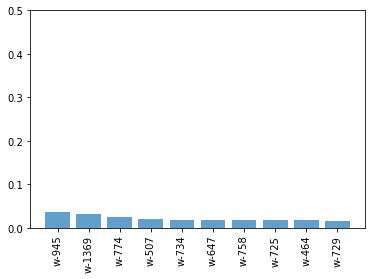

In [54]:
get_distr(X_rwalk, y_rwalk, label=1, indices=[2])

(16866, 100)


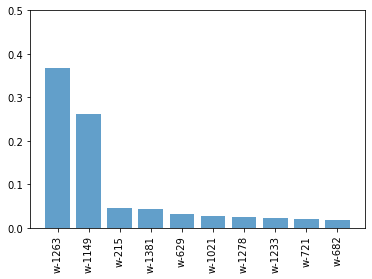

(16866, 100)


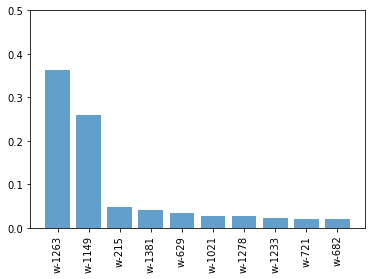

In [55]:
get_distr(X_l2, y_l2, label=0, indices=[16, 17])

In [ ]:
# get_distr(X_l2, y_l2, label=1, indices=[16, 17])

In [ ]:
# text_representation = tree.export_text(clf_l2)
# print(text_representation)

In [ ]:
# decision_path(clf_l2, le_l2, X_val_l2, y_val_l2, 1)

In [ ]:
# decision_path(clf_l2, le_l2, X_val_l2, y_val_l2, 10000)

In [ ]:
def get_mean(X, y, val):
    return np.mean(X.loc[[i for i in range(len(y)) if y[i]==val]].mean(axis=1))

In [ ]:
# get_mean(X_rwalk, y_rwalk, 0), get_mean(X_rwalk, y_rwalk, 1)

In [ ]:
# get_mean(X_minwise, y_minwise, 0), get_mean(X_minwise, y_minwise, 1)

In [ ]:
# get_mean(X_val_minwise, y_val_minwise, 0), get_mean(X_val_minwise, y_val_minwise, 1)

In [ ]:
# get_mean(X_ns, y_ns, 0), get_mean(X_ns, y_ns, 1)

In [ ]:
# get_mean(X_l1, y_l1, 0), get_mean(X_l1, y_l1, 1)

In [ ]:
# get_mean(X_l2, y_l2, 0), get_mean(X_l2, y_l2, 1)

# Other experiments, not reported in the paper

In [56]:
def get_auc_scores(X, y, X_val, y_val, lgb_params, label_encoder, n_splits):
    X_local = copy.deepcopy(X)
    for c in X_local.columns: 
        X_c = [str(x) for x in X_local[c]]
        X_local.loc[:, c] = label_encoder.transform(X_c)
        
    X_val_local = copy.deepcopy(X_val)
    for c in X_val_local.columns: 
        X_c = [str(x) for x in X_val_local[c]]
        X_val_local.loc[:, c] = label_encoder.transform(X_c)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
        
    classifiers = []
    
    folds = StratifiedKFold(n_splits=n_splits, random_state=73, shuffle=True) 
    splits = folds.split(X_local, y)
    for fold_n, (train_index, test_index) in enumerate(splits):
        print('Fold', fold_n)
        X_train, X_test = X_local.iloc[train_index], X_local.iloc[test_index]
        y_train, y_test = np.array(y)[train_index], np.array(y)[test_index]
        print(X_train.shape, X_test.shape)
        dtrain = lgb.Dataset(X_train, label=y_train)
        dtest = lgb.Dataset(X_test, label=y_test)

        clf = lgb.train(lgb_params, dtrain, valid_sets=[dtrain, dtest], verbose_eval=1000)
        classifiers.append((clf, clf.best_iteration))

        y_pred = clf.predict(X_val_local, num_iteration=clf.best_iteration)
        fpr, tpr, thresholds = roc_curve(y_val, y_pred)
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        del X_train, X_test, y_train, y_test
        gc.collect()
        
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)


    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

    return mean_auc, std_auc, mean_fpr, mean_tpr, tprs_lower, tprs_upper
    

In [57]:
def plot_roc_lgbm(X_rw, y_rw, X_rw_val, y_rw_val, \
                  X_mw, y_mw, X_mw_val, y_mw_val, \
                  X_l1, y_l1, X_l1_val, y_l1_val,\
                  features, name, exclude_pred = True, n_splits = 3):
    
    
    label_encoder = LabelEncoder()
    label_encoder.fit(features)
    nr_trees = 3000
    lgb_params = {'objective':'binary',
            'boosting_type':'gbdt',
            'metric':'auc',
            'n_jobs':4,
            'learning_rate':0.1,
            'tree_learner':'serial',
            'max_depth': -1,
            'n_estimators':nr_trees,
            'verbose':-1,
            'seed': 1}
    
    mean_auc_rw, std_auc_rw, mean_fpr_rw, mean_tpr_rw, tprs_lower_rw, tprs_upper_rw = \
                get_auc_scores(X_rw, y_rw, X_rw_val, y_rw_val, lgb_params, label_encoder, n_splits)
    
    lgb_params = {'objective':'binary',
            'boosting_type':'gbdt',
            'metric':'auc',
            'n_jobs':4,
            'learning_rate':0.1,
            'tree_learner':'serial',
            'max_depth': -1,
            'n_estimators':nr_trees,
            'verbose':-1,
            'seed': 1}
    
    mean_auc_mw, std_auc_mw, mean_fpr_mw, mean_tpr_mw, tprs_lower_mw, tprs_upper_mw = \
                get_auc_scores(X_mw, y_mw, X_mw_val, y_mw_val, lgb_params, label_encoder, n_splits)
    
    lgb_params = {'objective':'binary',
            'boosting_type':'gbdt',
            'metric':'auc',
            'n_jobs':4,
            'learning_rate':0.1,
            'tree_learner':'serial',
            'max_depth': -1,
            'n_estimators':nr_trees,
            'verbose':-1,
            'seed': 1}
    
    mean_auc_l1, std_auc_l1, mean_fpr_l1, mean_tpr_l1, tprs_lower_l1, tprs_upper_l1 = \
                get_auc_scores(X_l1, y_l1, X_l1_val, y_l1_val, lgb_params, label_encoder, n_splits)

    alpha = 0.7
    markersize=6
    markevery=5
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=alpha)

    plt.plot(mean_fpr_rw, mean_tpr_rw, color='b',
             label=r'AUC RW = %0.3f $\pm$ %0.4f' % (mean_auc_rw, std_auc_rw),
             lw=1, marker='o', markersize=markersize,  markevery=markevery, alpha=alpha)
   

    plt.plot(mean_fpr_mw, mean_tpr_mw, color='green',
             label=r'AUC $L_0$ = %0.3f $\pm$ %0.4f' % (mean_auc_mw, std_auc_mw),
             lw=1, markevery=markevery, marker='x', markersize=markersize, alpha=alpha)

    
    plt.plot(mean_fpr_l1, mean_tpr_l1, color='orange',
             label=r'AUC $L_1$ = %0.3f $\pm$ %0.4f' % (mean_auc_l1, std_auc_l1),
             lw=1, marker='D', markersize=markersize, markevery=markevery, alpha=alpha)

    plt.xlim([-0.05, 1.2])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    mytitle = name 
    plt.title(mytitle, fontsize=15)
    plt.legend(loc="lower right")
    plt.show()

In [58]:
# plot_roc_lgbm(X_rwalk, y_rwalk, X_val_rwalk, y_val_rwalk,
#               X_minwise, y_minwise, X_val_minwise, y_val_minwise,
#               X_l1, y_l1, X_val_l1, y_val_l1,
#               features, graphname +' ROC')

In [59]:
def lgbm_clf(X, y, X_test, y_test, label_encoder):
        
#         X_local = copy.deepcopy(X)
#         #encoders = {}
#         for c in X.columns: 
#             X_local.loc[:, c] = label_encoder.transform([str(x) for x in X_local[c]])
#             #encoders[c] = label_encoder
            
#         X_test_local = copy.deepcopy(X_test)
#         for c in X_test_local.columns: 
#             #label_encoder = encoders[c]
#             X_c = [str(x) for x in X_test_local[c]]
#             X_test_local.loc[:, c] = label_encoder.transform(X_c)
            
        lgb_params = {'objective':'binary',
            'boosting_type':'gbdt',
            'n_jobs':4,
            'learning_rate':0.1,
            'tree_learner':'serial',
            'max_depth': -1,
            'lambda_l1':10,
            'lambda_l2':10,
            'n_estimators':1000,
            'verbose':-1,
            'seed': 1}
        
        clf = lgb.LGBMClassifier( **lgb_params) 
        clf.fit(X, y, eval_set=[(X, y), (X_test, y_test)], early_stopping_rounds=100, verbose=1000)
        return clf